#Import Libraries

In [655]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.linalg import solve
from sklearn.metrics import mean_squared_error

np.random.seed(0)

#Download Data

In [656]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip
# !cd ml-100k/

#Helper Classes

In [657]:
class RecUtility:
  def __init__(self):
    self.ratings_df = None
    self.movie_index_dict = {}
    self.movie_genres_df = None
    self.genre_list = None
    self.user_movie_matrix = None
    self.user_vectors = None
    self.all_ratings_CB = None
    self.all_ratings_MF = None
    self.content_based_recommendations = None
    self.collaborative_recommendations = None

  def get_rated_items_for_user(self, user_id = 0):
      return ratings_df[ratings_df['user_id']==2].sort_values(by='item_id')['item_id']

  def set_movie_dict(self, movie_genres_df):
    self.movie_feature_dict = {}

    for i in range(movie_genres_df.shape[0]):
        index = i + 1
        self.movie_index_dict[index] = movie_genres_df.iloc[i][1]

    return "Movie feature dict saved successfully to class."

  def create_bar_plot(self, user_id = 0):

    # Sample data and labels
    data = self.user_vector[user_id].numpy()
    labels = self.genre_list

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(labels, data, color='skyblue')  # Create the bar plot
    plt.xlabel('Genres')
    plt.ylabel('Affinity')
    plt.title('User Vector (Affinity for genres)')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability

    # Show the bar plot
    plt.show()

  def recommendation_plotter(self, user_id = 0, rec_type = 'CB'):
    if rec_type == 'CB':
      rec = self.content_based_recommendations
    else:
      rec = self.collaborative_recommendations
    self.create_bar_plot(user_id-1)
    movie_list = list(rec_utility.movie_index_dict.values())
    np_df = np.array(rec_utility.movie_genres_df)
    plot_array = []
    movie_name_array = []
    labels = self.genre_list
    for numpy_array in [np.array(tensor.numpy()) for tensor in rec[user_id]]:
      movie_name = str(numpy_array)[2:-1]
      index = movie_list.index(movie_name)
      plot_array.append(np_df[index])
      movie_name_array.append(movie_name)

    movies = movie_name_array

    plot_array = np.array(plot_array)
    # Create subplots for the five bar plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # 1 row, 5 columns of subplots

    for i, ax in enumerate(axes):
        ax.bar(range(len(plot_array[i])), plot_array[i], color='skyblue')
        ax.set_xlabel('Genres')
        ax.set_ylabel('Movie Genres')
        ax.set_title(f'Movie: {movies[i]}')
        ax.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for readability
        ax.set_xticks(range(len(plot_array[i])))

    plt.tight_layout()  # Ensure the subplots are properly spaced
    plt.show()

  def create_recommendations(self, num_of_rec = 3, rec_type = 'CB'):
    movies_list = list(self.movie_index_dict.values())
    user_movies = self.user_movie_matrix
    num_users = user_movies.shape[0]
    user_topmovies = {}
    def find_user_top_movies(base_matrix, user_index, num_to_recommend):
        movies_ind = tf.nn.top_k(base_matrix[user_index], num_of_rec)[1]
        return tf.gather_nd(movies_list, tf.expand_dims(movies_ind, axis = 1))

    if rec_type == 'CB':
      num_to_recommend = tf.reduce_sum(tf.cast(tf.equal(users_movies, tf.zeros_like(users_movies)), dtype = tf.float32), axis = 1)
      for ind in range(num_users):
        top_movies = find_user_top_movies(self.all_ratings_CB, ind, tf.cast(num_to_recommend[ind], dtype = tf.int32))
        user_topmovies[user_ids[ind]] = list(top_movies)

      self.content_based_recommendations = user_topmovies
      return user_topmovies

    else:
      num_to_recommend = tf.reduce_sum(tf.cast(tf.equal(users_movies, tf.zeros_like(users_movies)), dtype = tf.float32), axis = 1)
      for ind in range(num_users):
        top_movies = find_user_top_movies(self.all_ratings_MF, ind, tf.cast(num_to_recommend[ind], dtype = tf.int32))
        user_topmovies[user_ids[ind]] = list(top_movies)

      self.collaborative_recommendations = user_topmovies
      return user_topmovies

In [658]:



class ExplicitMF():
    def __init__(self,
                 ratings,
                 n_factors=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):

        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):

        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI),
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda

            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI),
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors


    def get_mse(pred, actual):
        # Ignore nonzero terms.
        pred = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        return mean_squared_error(pred, actual)


    def train(self, n_iter=10):
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))

        self.partial_train(n_iter)

    def partial_train(self, n_iter):

        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs,
                                           self.item_vecs,
                                           self.ratings,
                                           self.user_reg,
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs,
                                           self.user_vecs,
                                           self.ratings,
                                           self.item_reg,
                                           type='item')
            ctr += 1

    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)

        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def calculate_learning_curve(self, iter_array, test):

        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [self.get_mse(predictions, self.ratings)]
            self.test_mse += [self.get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [659]:
rec_utility = RecUtility()

#Import Data (Create the user-movie matrix and movie-feature matrix)

##Create User-movie Matrix

In [660]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)

user_movie_matrix = ratings_df.pivot_table(index='user_id', columns='item_id', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)

user_movie_matrix = user_movie_matrix[:5]

user_movie_matrix.head()

##Save to rec_utility
rec_utility.ratings_df = ratings_df
rec_utility.user_movie_matrix = user_movie_matrix


##Create Movie-feature Matrix

In [661]:
movie_genres_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
movie_genres_df = movie_genres_df.drop(movie_genres_df.columns[[2, 3, 4]], axis=1)

#Save movie-feature dict
rec_utility.set_movie_dict(movie_genres_df)

'Movie feature dict saved successfully to class.'

In [662]:
movie_genres_df = movie_genres_df.drop(movie_genres_df.columns[[0,1]], axis = 1)

In [663]:
rec_utility.movie_genres_df = movie_genres_df

##Create Movie-genre List

In [664]:
movie_genres = pd.read_csv('ml-100k/u.genre', header= None)

In [665]:
rec_utility.genre_list = list(movie_genres[0])

#Check Shapes of created matrices

In [666]:
print("Shape of user-movie matrix: ", rec_utility.user_movie_matrix.shape)
print("Shape of movie-genres matrix: ", rec_utility.movie_genres_df.shape)
print("Shape of genre-list: ", len(rec_utility.genre_list))

Shape of user-movie matrix:  (5, 1682)
Shape of movie-genres matrix:  (1682, 19)
Shape of genre-list:  19


#Content Based Recommendation


##Content Based Algorithm

In [667]:
num_users = rec_utility.user_movie_matrix.shape[0]
num_movies = rec_utility.user_movie_matrix.shape[1]
num_feats = len(rec_utility.genre_list)


user_ids = rec_utility.user_movie_matrix.index

print(num_users,num_movies, num_feats)

5 1682 19


In [668]:
#Create Arrays to Tensorflow objects
users_movies = tf.constant(rec_utility.user_movie_matrix, dtype = tf.float32)
movies_feats = tf.constant(rec_utility.movie_genres_df, dtype = tf.float32)

#Create a movie-feature matrix by multiplying user rating
wgtd_feature_matrices=[tf.expand_dims(tf.transpose(users_movies)[:,i],axis=1)*movies_feats for i in range(num_users)]

#Stack these matrices to create one object
users_movies_feats = tf.stack(wgtd_feature_matrices)

#Sum all movie ratings for each user and normalize them to create a distribution over all genres summing to 1
users_movies_feats_sums = tf.reduce_sum(users_movies_feats, axis = 1)
users_movies_feats_totals = tf.reduce_sum(users_movies_feats_sums, axis = 1)

#Create user vector and store in rec_utility object
user_vector = [users_movies_feats_sums[i, :]/ users_movies_feats_totals[i]for i in range(num_users)]
rec_utility.user_vector = user_vector

#Create user rating for each movie by multiplying user vector to each movie (Most time consuming)
users_rating = [tf.map_fn(lambda x: tf.tensordot(user_vector[i], x, axes = 1), movies_feats) for i in range(num_users)]
all_users_ratings = tf.stack(users_rating)

#Create mask for masking already rated movies
all_users_ratings_new_CB = tf.where(tf.equal(users_movies, tf.zeros_like(users_movies)),
                                 all_users_ratings,
                                 -np.inf*tf.ones_like(tf.cast(users_movies, tf.float32)))

rec_utility.all_ratings_CB = all_users_ratings_new_CB

In [669]:
user_topmovies = rec_utility.create_recommendations(rec_type='CB', num_of_rec=3)

##Content Based Rec Testing

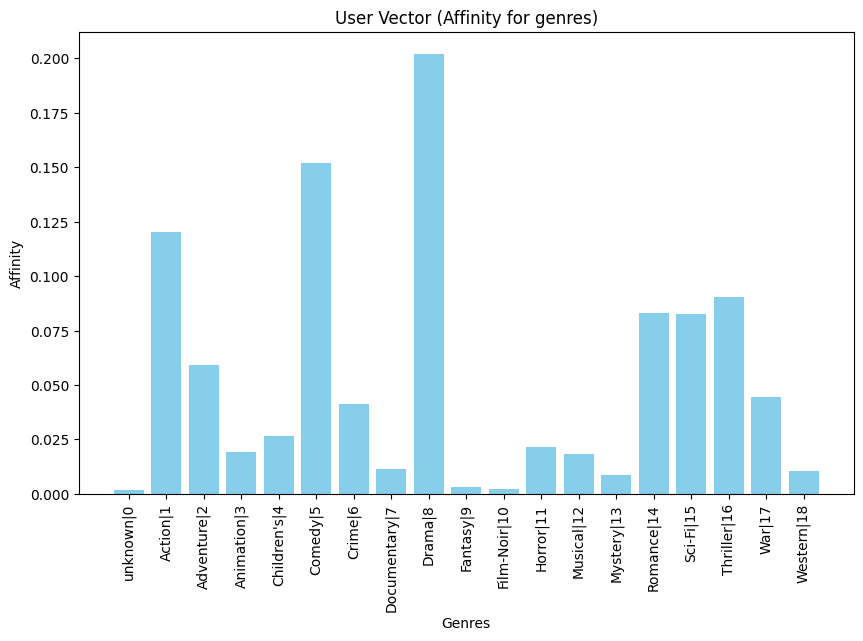

<ipython-input-657-6dd2c884848a>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for readability


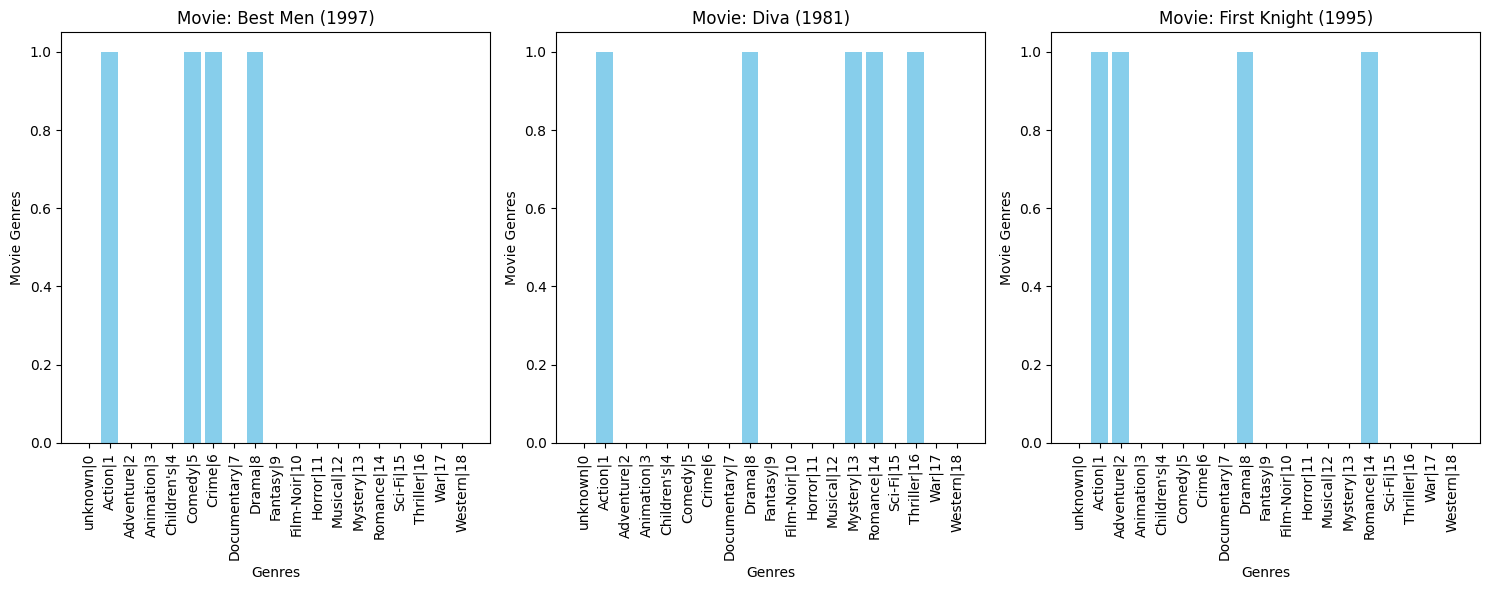

In [670]:
rec_utility.recommendation_plotter(user_id = 1, rec_type = 'CB')

#Matrix Factorization/ Collaborative Filtering

##MF Algorithm

In [671]:
ratings = np.array(rec_utility.user_movie_matrix)

In [672]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=10,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

In [673]:
train, test = train_test_split(ratings)

In [674]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [675]:
predictions = MF_ALS.predict_all()

In [676]:
predictions.shape

(5, 1682)

In [677]:
#Create mask for masking already rated movies
all_users_ratings_new_MF = tf.where(tf.equal(users_movies, tf.zeros_like(users_movies)),
                                 predictions,
                                 -np.inf*tf.ones_like(tf.cast(users_movies, tf.float32)))

rec_utility.all_ratings_MF = all_users_ratings_new_MF

In [678]:
rec_utility.collaborative_recommendations = all_users_ratings_new_MF

In [679]:
user_topmovies = rec_utility.create_recommendations(rec_type='MF', num_of_rec=3)

##MF Testing

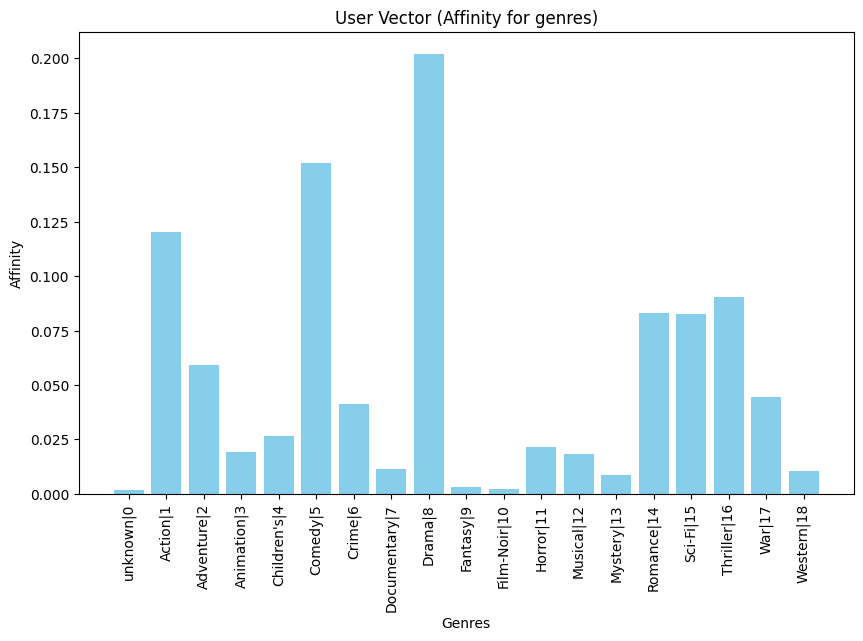

<ipython-input-657-6dd2c884848a>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for readability


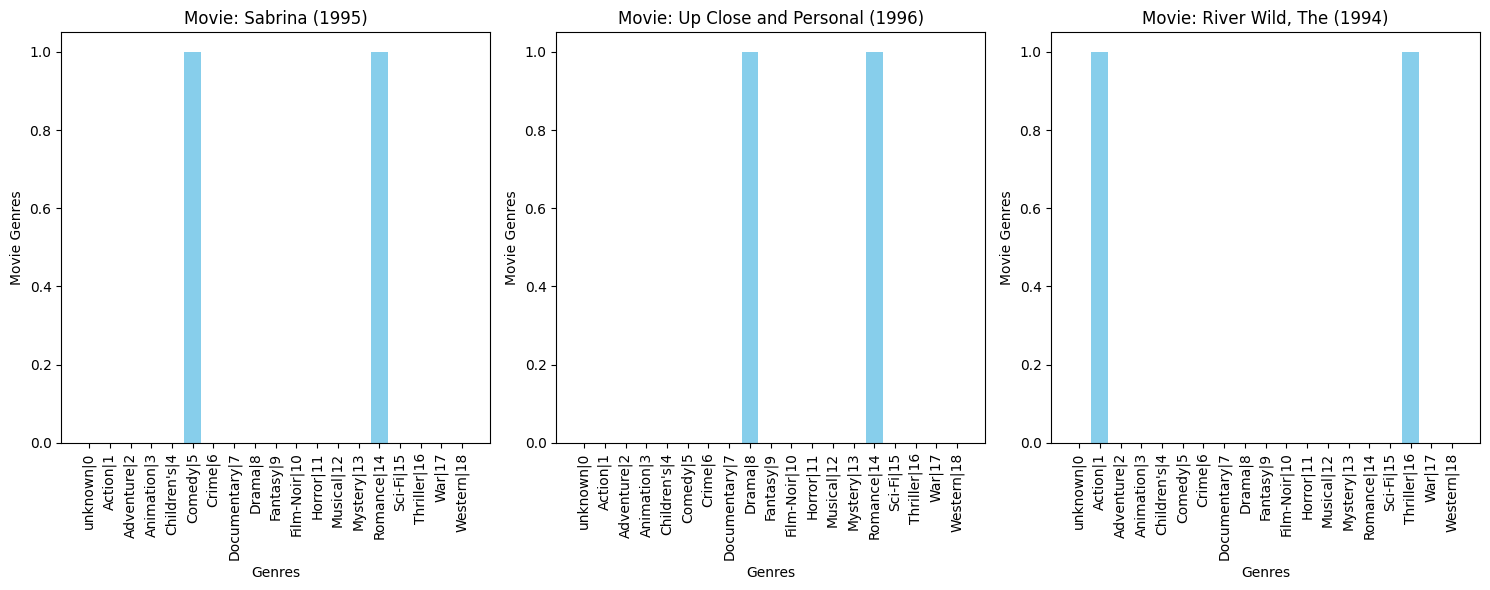

In [680]:
rec_utility.recommendation_plotter(user_id = 1, rec_type = 'MF')